In [14]:
import cv2
import torch
import argparse
import yaml
from torchvision import transforms
import onnxruntime as ort
from PIL import Image
from insightface.app import FaceAnalysis
from omegaconf import OmegaConf
from torchvision.transforms.functional import rgb_to_grayscale
import matplotlib.pyplot as plt

from src.utils.crops import *
from repos.stylematte.stylematte.models import StyleMatte
from src.utils.inference import *
from src.utils.inpainter import LamaInpainter
from src.utils.preblending import calc_pseudo_target_bg
from train_aligner import AlignerModule
from train_blender import BlenderModule

In [2]:
def torch2image(torch_image: torch.tensor) -> np.ndarray:
    batch = False
    
    if torch_image.dim() == 4:
        torch_image = torch_image[:8]
        batch = True
    
    device = torch_image.device
    mean = torch.tensor([0.5, 0.5, 0.5]).unsqueeze(1).unsqueeze(2).to(device)
    std = torch.tensor([0.5, 0.5, 0.5]).unsqueeze(1).unsqueeze(2).to(device)
    
    denorm_image = (std * torch_image) + mean
    
    if batch:
        denorm_image = denorm_image.permute(0, 2, 3, 1)
    else:
        denorm_image = denorm_image.permute(1, 2, 0)
    
    np_image = denorm_image.detach().cpu().numpy()
    np_image = np.clip(np_image*255., 0, 255).astype(np.uint8)
    
    if batch:
        return np.concatenate(np_image, axis=1)
    else:
        return np_image

In [10]:
with open('./configs/aligner.yaml', "r") as stream:
    cfg_a = OmegaConf.load(stream)
 
aligner = AlignerModule(cfg_a)
aligner.load_state_dict(torch.load('aligner_checkpoints/aligner_1020_gaze_final.ckpt'), strict=False)
aligner.eval()
aligner.cuda();

Looking for checkpoint in 'repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints'
Found 1 checkpoints
 - repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt
Selecting checkpoint 'repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt'


/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.4.9 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt`


n_param 236


/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


creating the FLAME Decoder
trained model found. load ./repos/DECA/data/deca_model.tar


ERROR:iopath.common.file_io:An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:548: UserWarning: Mtl file does not exist: ./repos/DECA/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [11]:
with open('./configs/blender.yaml', "r") as stream:
    cfg_b = OmegaConf.load(stream)

blender = BlenderModule(cfg_b)
blender.load_state_dict(torch.load('blender_checkpoints/blender_lama.ckpt', map_location='cpu')["state_dict"], strict=False,)
blender.eval()
blender.cuda()

inpainter = LamaInpainter();

In [12]:
app = FaceAnalysis(providers=['CUDAExecutionProvider'], allowed_modules=['detection'])
app.prepare(ctx_id=0, det_size=(640, 640))

/home/jovyan/.mlspace/envs/avatars5/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/jovyan/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/jovyan/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/jovyan/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/jovyan/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


## Preprocess

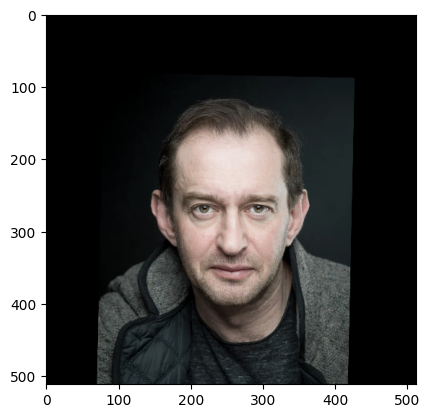

In [52]:
source_full = cv2.imread('./examples/images/hab.jpg')
dets = app.get(source_full)
kps = dets[0]['kps']
source = wide_crop_face(source_full, kps)
plt.imshow(source[:,:,::-1])

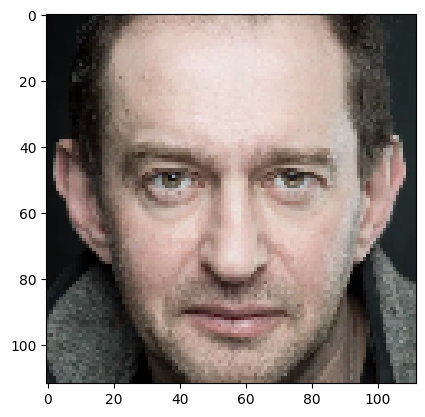

In [16]:
source_arc = norm_crop(source_full, kps)
plt.imshow(source_arc[:,:,::-1])

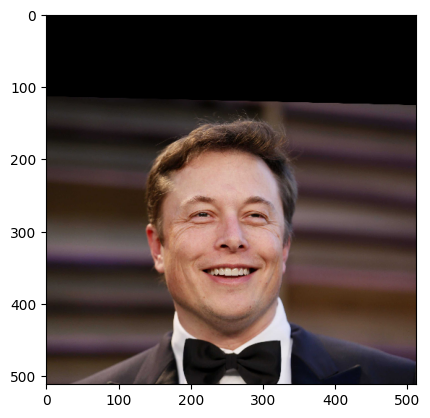

In [54]:
full_frames = cv2.imread('./examples/images/elon.jpg')
dets = app.get(full_frames)
kps = dets[0]['kps']
target = wide_crop_face(full_frames, kps, return_M=True)
target, M = target
plt.imshow(target[:,:,::-1])

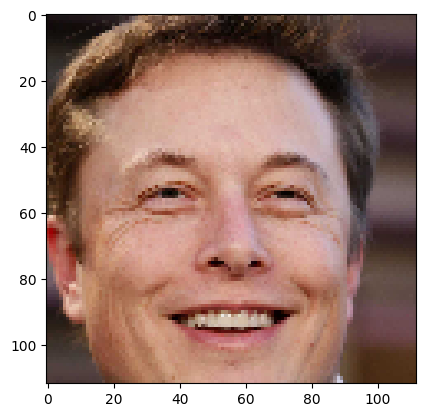

In [55]:
target_arc = norm_crop(full_frames, kps)
plt.imshow(target_arc[:,:,::-1])

## Mask

In [56]:
from repos.stylematte.stylematte.models import StyleMatte
segment_model = StyleMatte()
segment_model.load_state_dict(
    torch.load(
        '/home/jovyan/yaschenko/headswap/repos/stylematte/stylematte/checkpoints/drive-download-20230511T084109Z-001/stylematte_synth.pth',
        map_location='cpu'
    )
)
segment_model = segment_model.cuda()
segment_model.eval()
None

In [97]:
 def calc_mask(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).permute(2, 0, 1).cuda()
    if img.max() > 1.:
        img = img / 255.0
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    input_t = normalize(img)
    input_t = input_t.unsqueeze(0).float()
    with torch.no_grad():
        out = segment_model(input_t)
    result = out[0]

    return result[0]

In [98]:
source_mask = calc_mask(source).unsqueeze(0).unsqueeze(0).unsqueeze(0)
target_mask = calc_mask(target).unsqueeze(0).unsqueeze(0)

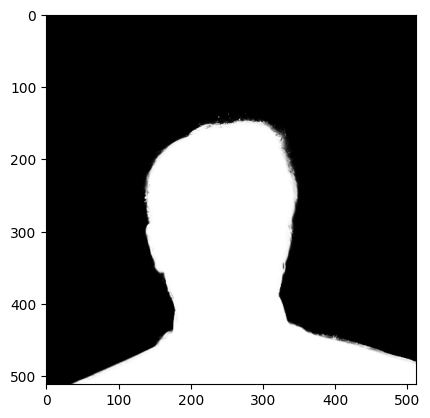

In [99]:
plt.imshow(target_mask[0].detach().cpu().permute(1, 2, 0), cmap='gray')

### Aligner

In [60]:
def normalize_and_torch(image: np.ndarray, use_cuda = True) -> torch.tensor:
    """
    Normalize image and transform to torch
    """
    if use_cuda:
        image = torch.tensor(image.copy(), dtype=torch.float32).cuda()
    else:
        image = torch.tensor(image.copy(), dtype=torch.float32)
    if image.max() > 1.:
        image = image/255.
    
    image = image.permute(2, 0, 1).unsqueeze(0)
    image = (image - 0.5) / 0.5

    return image

In [61]:
norm_source_arc = normalize_and_torch(source_arc).unsqueeze(0)
norm_target_arc = normalize_and_torch(target_arc)

norm_source = normalize_and_torch(source).unsqueeze(0)
norm_target = normalize_and_torch(target)

In [62]:
X_dict = {
        'source': {
            'face_arc': norm_source_arc,
            'face_wide': norm_source * source_mask,
            'face_wide_mask': source_mask,
        },
        'target': {
            'face_arc': norm_target_arc,
            'face_wide': norm_target * target_mask,
            'face_wide_mask': target_mask,
        }
    }

In [63]:
output = aligner(X_dict)

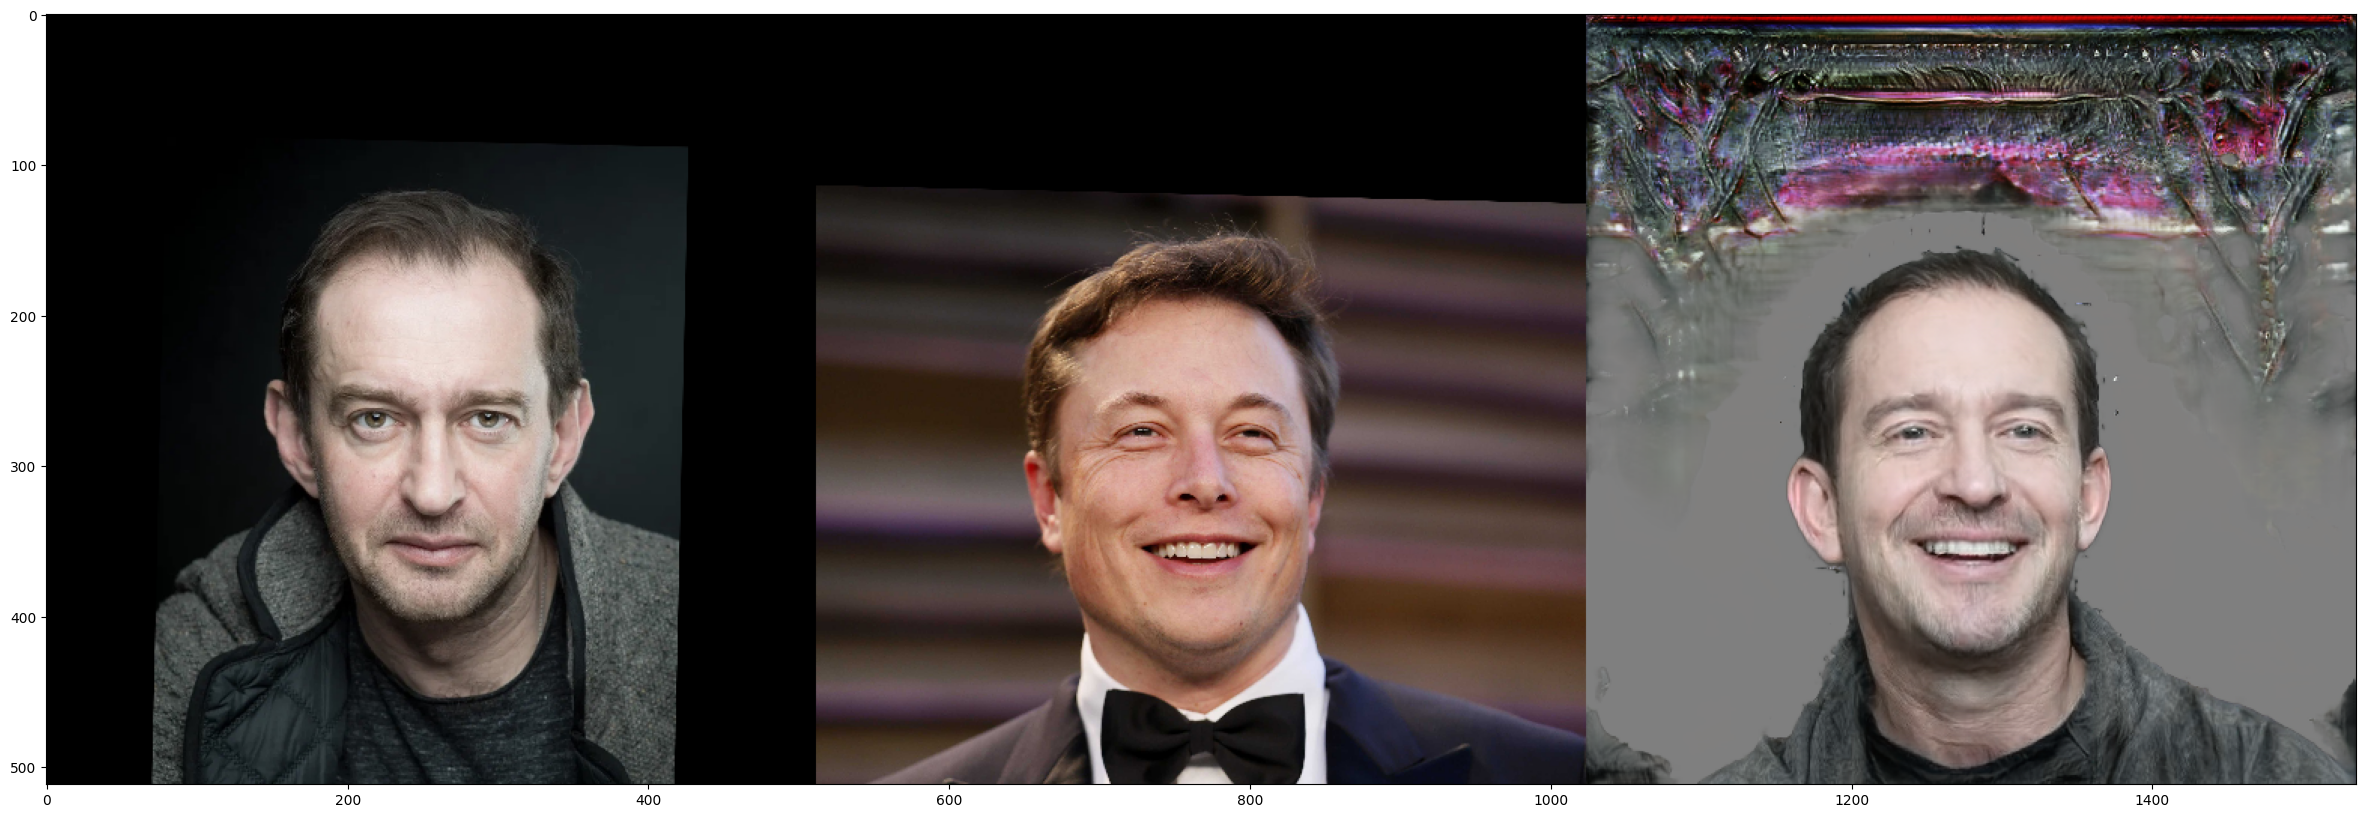

In [65]:
plt.figure(figsize=(30, 10))
np_output = np.uint8((output['fake_rgbs'][0].detach().cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5) * 255)
output_for_video = np.concatenate([source, target, np_output], axis =1)
plt.imshow(output_for_video[:,:,::-1])

### Blender

In [78]:
providers = [
       ("CUDAExecutionProvider", {})
    ]
parsings_session = ort.InferenceSession('/home/jovyan/paramonov/segmentation/models/segformer_B5_ce.onnx', providers=providers)
input_name = parsings_session.get_inputs()[0].name
output_names = [output.name for output in parsings_session.get_outputs()]

mean = np.array([0.51315393, 0.48064056, 0.46301059])[None, :, None, None]
std = np.array([0.21438347, 0.20799829, 0.20304542])[None, :, None, None]


In [94]:
infer_parsing = lambda img: torch.tensor(
    parsings_session.run(output_names, {
        input_name: (((img[:, [2, 1, 0], ...] / 2 + 0.5).cpu().detach().numpy() - mean) / std).astype(np.float32)
    })[0],
    device='cuda',
    dtype=torch.float32
)

In [100]:
target_parsing = infer_parsing(norm_target)
pseudo_norm_target = calc_pseudo_target_bg(norm_target, target_parsing)
soft_mask = calc_mask(((output['fake_rgbs'] * output['fake_segm'])[0, [2, 1, 0], :, :] + 1) / 2)[None]
new_source = output['fake_rgbs'] * soft_mask[:, None, ...] + pseudo_norm_target * (1 - soft_mask[:, None, ...])

In [102]:
blender_input = {
        'face_source': new_source, # output['fake_rgbs']*output['fake_segm'] + norm_target*(1-output['fake_segm']),# face_source,
        'gray_source': rgb_to_grayscale(new_source[0][[2, 1, 0], ...]).unsqueeze(0),
        'face_target': norm_target,
        'mask_source': infer_parsing(output['fake_rgbs']*output['fake_segm']),
        'mask_target': target_parsing,
        'mask_source_noise': None,
        'mask_target_noise': None,
        'alpha_source': soft_mask
    }

In [103]:
output_b = blender(blender_input, inpainter=inpainter)

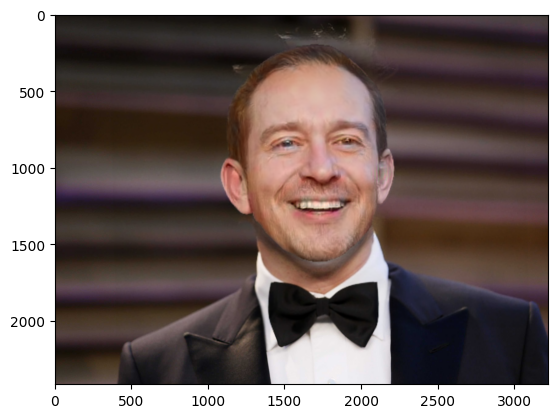

In [107]:
np_output = np.uint8((output_b['oup'][0].detach().cpu().numpy().transpose((1, 2, 0))[:,:,::-1] / 2 + 0.5)*255)
result = copy_head_back(np_output, full_frame[..., ::-1], M)
plt.imshow(result)